In [1]:
import json, requests, time
from sqlalchemy import create_engine
import pandas as pd

engine = create_engine('postgresql://postgres:argmax@pg:5432/postgres')


# Data
Every time a user opens a mobile app, an auction is going on behind the scenes. The highest bidder gets to advertise his ad to the user.
## Auctions Table

In [2]:
sql_query = 'SELECT * FROM auctions;'
with engine.connect() as db_con:
    df = pd.read_sql(sql_query, con=db_con)

df

,id,eventTimestamp,unitDisplayType,brandName,bundleId,countryCode,deviceId,osAndVersion,bidFloorPrice,sentPrice
0,1,1657758857892,rewarded,Generic,com.loop.match3d,US,6a0a94554cf,Android-4.0,0.05,0.06
1,2,1657210707978,interstitial,Generic,com.loop.match3d,ZA,6a0b0e59f45,Android-4.0,0.01,0.16
2,3,1657392939412,interstitial,Motorola,com.YayySAL.DodgeAgent,BR,6a0fa820c46,Android-10.0,0.05,0.06
3,4,1657386816882,interstitial,Huawei,com.tintash.nailsalon,IQ,6a142bdbea2,Android-9.0,0.01,0.05
4,5,1657211600823,banner,Generic,com.tilegarden.match3,US,6a16943a771,Android-4.0,0.01,0.03
...,...,...,...,...,...,...,...,...,...,...
41579,41580,1657731605063,banner,Generic,com.tilegarden.match3,NZ,80edf5837e8,Android-4.0,0.01,0.02
41580,41581,1657657131101,interstitial,Apple,1436213906,VN,80ee6a5eebf,iOS-13.6,0.01,0.90
41581,41582,1657156070854,rewarded,Generic,com.loop.match3d,US,80efe531afc,Android-4.0,0.05,0.69
41582,41583,1657659603568,banner,Apple,1502447854,US,80f02dd397f,iOS-15.0,0.01,0.10


## App Vectors table
We've gathered the first few sentences from the app store description and embedded it with a [model](https://huggingface.co/mixedbread-ai/mxbai-embed-large-v1)

In [3]:
sql_query = f'''
SELECT
    *
FROM app_vectors
'''
has_embedding = False
while not has_embedding:
    with engine.connect() as db_con:
        app_vectors = pd.read_sql(sql_query, con=db_con)
    has_embedding = (~app_vectors["embedding"].isna()).all()
    if not has_embedding:
        print("Waiting for embeddings...")
        time.sleep(15)

app_vectors


,id,bundleId,content,embedding
0,1,com.loop.match3d,"Get ready for a new, challenging and original ...","[0.31683657,0.6250096,-0.12035612,0.21742296,-..."
1,2,com.YayySAL.DodgeAgent,"Your mission, should you choose to accept it, ...","[0.54112995,0.74467605,-0.58174556,0.9596781,0..."
2,3,com.tintash.nailsalon,It is manicure madness over here and it�s your...,"[0.31176758,0.6059474,-1.139566,0.07630952,-0...."
3,4,com.tilegarden.match3,\nIf you enjoy playing Match 3 tile & mahjong ...,"[0.05092397,1.0967331,-0.30831552,0.13220598,-..."
4,6,com.AppIdeas.LevelUpRunner,"Are you a real hero? Are you the strongest, th...","[0.8975636,0.4644263,-0.1801914,1.2617054,0.07..."
5,17,1582745578,Dominate the coal industry and become the next...,"[0.88490415,0.6585203,-0.33866996,0.18323657,0..."
6,18,1569586264,Choose the appropriate outfit to make it throu...,"[0.20005348,0.3608348,-0.137923,0.34308633,-0...."
7,5,com.kamilbilge.ropesavior3d,Become the hero we need in this tangled puzzle...,"[0.51124793,0.512806,-0.056304544,1.2819325,0...."
8,7,se.ace.fishinc,Gather your riches and travel across the open ...,"[0.73094386,0.41121805,-0.6196006,0.5350147,0...."
9,8,com.volt.dresstoimpress,\nChoose the appropriate outfit to make it thr...,"[0.20005348,0.3608348,-0.137923,0.34308633,-0...."


We can use the `<=>` operator to run vector search within the database

In [4]:

vec = json.loads(app_vectors.embedding[0]) # get the first embedding
print ("Embedding size: {l}".format(l=len(vec)))

sql_query = f'''
SELECT
    *
FROM app_vectors
ORDER BY embedding<=>'{json.dumps(vec)}'
'''
with engine.connect() as db_con:
    df = pd.read_sql(sql_query, con=db_con)

df

Embedding size: 1024


,id,bundleId,content,embedding
0,1,com.loop.match3d,"Get ready for a new, challenging and original ...","[0.31683657,0.6250096,-0.12035612,0.21742296,-..."
1,12,1502447854,"Get ready for a new, challenging and original ...","[0.2941418,0.63447547,-0.03819034,0.21263441,-..."
2,10,1529614832,Are you a fan of match-three & matching games?...,"[0.36212623,0.839175,-0.33567247,0.0013338662,..."
3,4,com.tilegarden.match3,\nIf you enjoy playing Match 3 tile & mahjong ...,"[0.05092397,1.0967331,-0.30831552,0.13220598,-..."
4,5,com.kamilbilge.ropesavior3d,Become the hero we need in this tangled puzzle...,"[0.51124793,0.512806,-0.056304544,1.2819325,0...."
5,15,1579489488,Become the hero we need in this tangled puzzle...,"[0.51124793,0.512806,-0.056304544,1.2819325,0...."
6,13,1436213906,Gather your riches and travel across the open ...,"[0.85033816,0.348396,-0.61324424,0.5529508,0.0..."
7,16,1586795332,"Are you a real hero? Are you the strongest, th...","[0.8975636,0.4644263,-0.1801914,1.2617054,0.07..."
8,6,com.AppIdeas.LevelUpRunner,"Are you a real hero? Are you the strongest, th...","[0.8975636,0.4644263,-0.1801914,1.2617054,0.07..."
9,7,se.ace.fishinc,Gather your riches and travel across the open ...,"[0.73094386,0.41121805,-0.6196006,0.5350147,0...."


# What you need to do
## The hypothesis
We assume that apps with similar desciptions, would have a similar asking price in the auctions (`sentPrice` column).

Use cosine similarity (`<=>`) on the embeddings to find similar apps, and any statistical tools you find suitable to prove or disprove this hypothesis.

## Is it consistent?
There are several other features in the auctions table (such as `CountryCode` and `OS`), 
Do your findings hold for those as well?

In [5]:
# TODO: Please write your analysis here

# approach
first we'll make new dataFrames to hold the tables we will manipulate
## Auctions Table

In [6]:

sql_query = 'SELECT * FROM auctions;'
with engine.connect() as db_con:
    auctions = pd.read_sql(sql_query, con=db_con)


 ## remove unused collumns :

In [7]:
auctions.drop('eventTimestamp', axis=1, inplace=True)
auctions.drop('deviceId', axis=1, inplace=True)
auctions.drop('bidFloorPrice', axis=1, inplace=True)
auctions

,id,unitDisplayType,brandName,bundleId,countryCode,osAndVersion,sentPrice
0,1,rewarded,Generic,com.loop.match3d,US,Android-4.0,0.06
1,2,interstitial,Generic,com.loop.match3d,ZA,Android-4.0,0.16
2,3,interstitial,Motorola,com.YayySAL.DodgeAgent,BR,Android-10.0,0.06
3,4,interstitial,Huawei,com.tintash.nailsalon,IQ,Android-9.0,0.05
4,5,banner,Generic,com.tilegarden.match3,US,Android-4.0,0.03
...,...,...,...,...,...,...,...
41579,41580,banner,Generic,com.tilegarden.match3,NZ,Android-4.0,0.02
41580,41581,interstitial,Apple,1436213906,VN,iOS-13.6,0.90
41581,41582,rewarded,Generic,com.loop.match3d,US,Android-4.0,0.69
41582,41583,banner,Apple,1502447854,US,iOS-15.0,0.10


## install seaborn if needed

In [9]:
# !pip install seaborn

## let's try to see how the prices data distributes using box plot

<Axes: xlabel='bundleId', ylabel='sentPrice'>

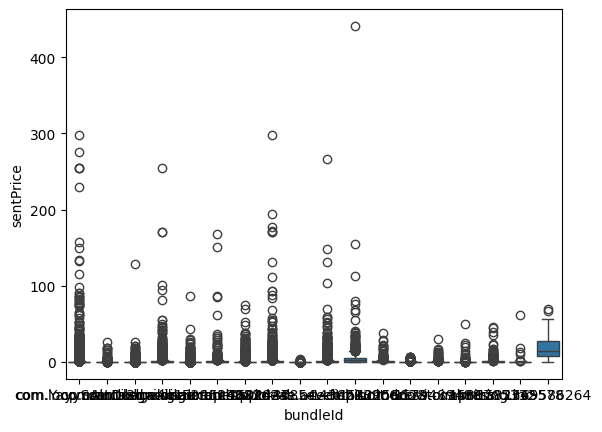

In [20]:
# Box Plot 
import seaborn as sns
sns.boxplot(x='bundleId', y='sentPrice', data=auctions)


## looks like the data is not clear and many differences between averages and medians exist
 x axis is not shown well, but i'll ignore that for now since i don'y want to enumerate all bundleIds
## so we will try to clean up some data:

In [21]:
auctions97 = auctions.copy(deep=True)

auctions97['threshold'] = auctions.groupby('bundleId')['sentPrice'].transform(lambda x: x.quantile(0.97))

# Filter the DataFrame to exclude outliers
auctions97 = auctions97[auctions97['sentPrice'] <= auctions97['threshold']]

auctions97


,id,unitDisplayType,brandName,bundleId,countryCode,osAndVersion,sentPrice,threshold
0,1,rewarded,Generic,com.loop.match3d,US,Android-4.0,0.06,10.0300
1,2,interstitial,Generic,com.loop.match3d,ZA,Android-4.0,0.16,10.0300
2,3,interstitial,Motorola,com.YayySAL.DodgeAgent,BR,Android-10.0,0.06,2.4828
3,4,interstitial,Huawei,com.tintash.nailsalon,IQ,Android-9.0,0.05,1.5900
4,5,banner,Generic,com.tilegarden.match3,US,Android-4.0,0.03,14.8302
...,...,...,...,...,...,...,...,...
41579,41580,banner,Generic,com.tilegarden.match3,NZ,Android-4.0,0.02,14.8302
41580,41581,interstitial,Apple,1436213906,VN,iOS-13.6,0.90,19.1460
41581,41582,rewarded,Generic,com.loop.match3d,US,Android-4.0,0.69,10.0300
41582,41583,banner,Apple,1502447854,US,iOS-15.0,0.10,12.7836


## box plot

<Axes: xlabel='bundleId', ylabel='sentPrice'>

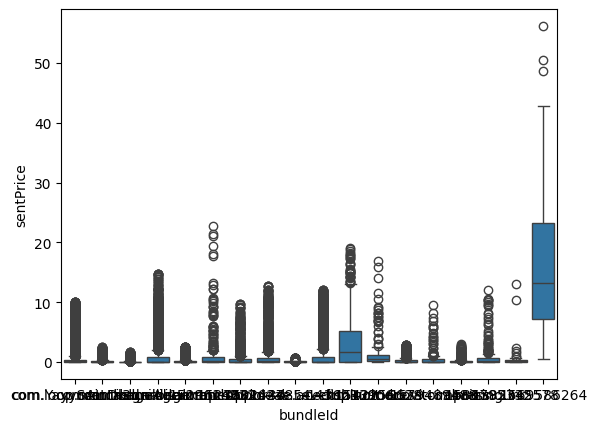

In [22]:
sns.boxplot(x='bundleId', y='sentPrice', data=auctions97)


## we can see the data distributes alittle clearer but not as good as expected
## but this is the best we can do for time limit


In [23]:
## calculate average and median on all the data 

medians = auctions.groupby("bundleId")["sentPrice"].median().reset_index()
medians
avgs = auctions.groupby("bundleId")["sentPrice"].mean().reset_index()
avgs
stats_all_data = pd.merge(medians, avgs, on="bundleId", suffixes=('_median', '_mean'))
stats_all_data


,bundleId,sentPrice_median,sentPrice_mean
0,1436213906,1.940,4.718555
1,1502447854,0.160,2.269482
2,1523081624,0.070,1.101837
3,1529614832,0.110,3.121816
4,1542256628,0.465,2.114797
5,1569586264,13.905,18.900179
6,1579489488,0.080,1.113208
7,1582745578,0.110,2.179091
8,1586795332,0.160,1.598364
9,com.AppIdeas.LevelUpRunner,0.070,0.131547


In [24]:
# calculate average and median on the filtered data

medians = auctions97.groupby("bundleId")["sentPrice"].median().reset_index()
medians
avgs = auctions97.groupby("bundleId")["sentPrice"].mean().reset_index()
avgs
stats_97p_data = pd.merge(medians, avgs, on="bundleId", suffixes=('_median', '_mean'))
stats_97p_data


,bundleId,sentPrice_median,sentPrice_mean
0,1436213906,1.670,3.344112
1,1502447854,0.150,1.093179
2,1523081624,0.060,0.492937
3,1529614832,0.100,1.299684
4,1542256628,0.445,1.364454
5,1569586264,13.130,17.090556
6,1579489488,0.080,0.628405
7,1582745578,0.100,0.739057
8,1586795332,0.140,0.829837
9,com.AppIdeas.LevelUpRunner,0.070,0.098627


## now let's try to calculate all the cosine similarities between all the different apps:

In [25]:
sql_query = f'''
SELECT
    a1."bundleId" AS bundleId1,
    a2."bundleId" AS bundleId2,
    a1.embedding <=> a2.embedding AS similarity
    
FROM
    app_vectors a1
CROSS JOIN
    app_vectors a2
WHERE
    a1."bundleId" < a2."bundleId"
ORDER BY
    similarity;

'''
with engine.connect() as db_con:
    app_vectors_crossed = pd.read_sql(sql_query, con=db_con)

app_vectors_crossed

,bundleid1,bundleid2,similarity
0,1542256628,com.YayySAL.DodgeAgent,0.000000
1,1569586264,com.volt.dresstoimpress,0.000000
2,1523081624,com.tintash.nailsalon,0.000000
3,1582745578,dovi.coalmining.inc,0.000000
4,1579489488,com.kamilbilge.ropesavior3d,0.000000
...,...,...,...
148,com.tintash.nailsalon,com.YayySAL.DodgeAgent,0.610830
149,com.volt.dresstoimpress,dovi.coalmining.inc,0.622133
150,1569586264,1582745578,0.622133
151,1569586264,dovi.coalmining.inc,0.622133


## calculate pearson correlation between the similarity and the sentPrices stats of ALL the data / sanity check

In [26]:

apps_stats = stats_all_data.join(stats_all_data, lsuffix='_left', rsuffix='_right', how='cross')
apps_stats
correlation = app_vectors_crossed['similarity'].corr(apps_stats['sentPrice_median_left'])
print("correlation with median",correlation)

correlation = app_vectors_crossed['similarity'].corr(apps_stats['sentPrice_mean_left'])
print("correlation with mean",correlation)



correlation with median 0.05891241937342029
correlation with mean 0.02161441940843182


## finding correlation between the similarity and the sentPrices stats on our filtered data

In [27]:
# correlation 97 quant

apps_stats = stats_97p_data.join(stats_97p_data, lsuffix='_left', rsuffix='_right', how='cross')
apps_stats
correlation = app_vectors_crossed['similarity'].corr(apps_stats['sentPrice_median_left'])
print("correlation with median",correlation)

correlation = app_vectors_crossed['similarity'].corr(apps_stats['sentPrice_mean_left'])
print("correlation with mean",correlation)


correlation with median 0.06914906473512746
correlation with mean 0.03587833496316457


## unfortunately the results don't look promising and no linear correlation was found

# let's see if we can extract some correlation with alittle manipulation like log/sqrt :


In [29]:
import math

# Assuming merged_100 is your DataFrame containing the merged data

# Perform a cross join to create all combinations of rows
#apps_stats = merged_100.merge(merged_100, lsuffix='_left', rsuffix='_right', how='cross')

# Assuming app_vectors_crossed is your DataFrame containing the 'similarity' column

# Transform the 'sentPrice_median_left' column using a logarithmic transformation
apps_stats['log_sentPrice_median_left'] = apps_stats['sentPrice_median_left'].apply(lambda x: math.log(x) if x > 0 else 0)
apps_stats['log_sentPrice_mean_left'] = apps_stats['sentPrice_mean_left'].apply(lambda x: math.log(x) if x > 0 else 0)

# Transform the 'sentPrice_mean_left' column using a square root transformation
apps_stats['sqrt_sentPrice_mean_left'] = apps_stats['sentPrice_mean_left'].apply(lambda x: math.sqrt(x) if x >= 0 else 0)
apps_stats['sqrt_sentPrice_median_left'] = apps_stats['sentPrice_median_left'].apply(lambda x: math.sqrt(x) if x >= 0 else 0)

# Calculate the correlation between the transformed columns and the 'similarity' column
log_corr_median = app_vectors_crossed['similarity'].corr(apps_stats['log_sentPrice_median_left'])
log_corr_mean = app_vectors_crossed['similarity'].corr(apps_stats['log_sentPrice_mean_left'])
sqrt_corr_median = app_vectors_crossed['similarity'].corr(apps_stats['sqrt_sentPrice_median_left'])
sqrt_corr_mean = app_vectors_crossed['similarity'].corr(apps_stats['sqrt_sentPrice_mean_left'])

print("Correlation with log_sentPrice_median_left:", log_corr_median)
print("Correlation with sqrt_sentPrice_mean_left:", sqrt_corr_mean)
print("Correlation with log_sentPrice_mean_left:", log_corr_mean)
print("Correlation with sqrt_sentPrice_median_left:", sqrt_corr_median)

Correlation with log_sentPrice_median_left: -0.2679315108424879
Correlation with sqrt_sentPrice_mean_left: -0.07797883704891138
Correlation with log_sentPrice_mean_left: -0.22119040121341477
Correlation with sqrt_sentPrice_median_left: -0.07063517873411601


In [110]:
auctions_combined = app_vectors.merge(auctions, on="bundleId")
auctions_combined

,id_x,bundleId,content,embedding,id_y,brandName,countryCode,osAndVersion,sentPrice
0,1,com.loop.match3d,"Get ready for a new, challenging and original ...","[0.31683657,0.6250096,-0.12035612,0.21742296,-...",1,Generic,US,Android-4.0,0.06
1,1,com.loop.match3d,"Get ready for a new, challenging and original ...","[0.31683657,0.6250096,-0.12035612,0.21742296,-...",2,Generic,ZA,Android-4.0,0.16
2,1,com.loop.match3d,"Get ready for a new, challenging and original ...","[0.31683657,0.6250096,-0.12035612,0.21742296,-...",6,Xiaomi,CL,Android-11.0,0.24
3,1,com.loop.match3d,"Get ready for a new, challenging and original ...","[0.31683657,0.6250096,-0.12035612,0.21742296,-...",7,Motorola,MX,Android-9.0,0.02
4,1,com.loop.match3d,"Get ready for a new, challenging and original ...","[0.31683657,0.6250096,-0.12035612,0.21742296,-...",14,Vivo,PH,Android-8.1.0,0.30
...,...,...,...,...,...,...,...,...,...
41579,16,1586795332,"Are you a real hero? Are you the strongest, th...","[0.8975636,0.4644263,-0.1801914,1.2617054,0.07...",41327,Apple,JP,iOS-15.4,0.19
41580,16,1586795332,"Are you a real hero? Are you the strongest, th...","[0.8975636,0.4644263,-0.1801914,1.2617054,0.07...",41404,Apple,GR,iOS-12.1,0.64
41581,16,1586795332,"Are you a real hero? Are you the strongest, th...","[0.8975636,0.4644263,-0.1801914,1.2617054,0.07...",41483,Apple,US,iOS-12.1.1,7.96
41582,16,1586795332,"Are you a real hero? Are you the strongest, th...","[0.8975636,0.4644263,-0.1801914,1.2617054,0.07...",41535,Apple,CA,iOS-15.5,0.52


# I was trying 1 hot encoding on the countryCode to see if we can find better correlation to sentPrice
# but didn't have enough time

# conclusions:

I could not find correlation between the similarity of application content description and prices sent to auctions.
best result i got was Correlation with log on mean value : -0.22119040121341477 
which indicates a small linear negative correlation but is not good enough to approve the hypothesis.

## therefore i would say the hypothesis is wrong.

## I would continue to check if countryCode may have effect on the prices, by embedding it and comparing or combining with the content similarity.

